#**Predicting Solubility of Molecules**

**1.Install Rdkit**

In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-07-09 14:00:37--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   220MB/s    in 0.4s    

2020-07-09 14:00:37 (220 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

**2.1 Import dataset**

In [2]:

! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

--2020-07-09 14:02:58--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv’

delaney.csv         100%[===================>]  57.51K  --.-KB/s    in 0.02s   

2020-07-09 14:02:59 (3.48 MB/s) - ‘delaney.csv’ saved [58889/58889]



**2.2. Read in the dataset**

In [3]:
import pandas as pd

In [4]:
sol = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bio informatics project/delaney.csv')

In [5]:
sol.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


**2.3. Examining the SMILES data**

Chemical structures are encoded by a string of text known as SMILES which is an acronym for ***Simplified Molecular-Input Line-Entry System***

In [6]:
sol.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

**2.4. Convert a molecule from the SMILES string to an rdkit object**

In [7]:
from rdkit import Chem

In [8]:
Chem.MolFromSmiles(sol.SMILES[0])

**2.5. Working with rdkit object**

In [9]:
m = Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

In [10]:
m.GetNumAtoms()

6


#3. Calculate molecular descriptors in rdkit

**3.1. Convert list of molecules to rdkit object**

In [11]:
from rdkit import Chem

In [12]:
mol_list2 = [Chem.MolFromSmiles(element) for element in sol.SMILES]

In [13]:
len(mol_list2)

1144

In [14]:
mol_list2[:5]

**3.2. Calculate molecular descriptors**

To predict LogS (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:



1.   cLogP (Octanol-water partition coefficient)
2.   MW (Molecular weight)
3.   RB (Number of rotatable bonds)
4.   AP (Aromatic proportion = number of aromatic atoms / total number of heavy atoms)


Unfortunately, rdkit readily computes the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the number of aromatic atoms to the total number of heavy atoms which rdkit can compute.

**3.2.1. LogP, MW and RB**

In [15]:

import numpy as np
from rdkit.Chem import Descriptors

In [16]:
def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolLogP","MolWt","NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [17]:
df = generate(sol.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


**3.2.2. Aromatic proportion**

**3.2.1.1. Number of aromatic atoms**

Here, we will create a custom function to calculate the Number of aromatic atoms. With this descriptor we can use it to subsequently calculate the AP descriptor.

Computing for a single molecule.

In [18]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')

In [19]:

aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
aromatic_atoms

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [20]:

def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [21]:
AromaticAtoms(m)

19

Computing for molecules in the entire dataset

In [23]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list2]
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

**3.2.1.2. Number of heavy atoms**

In [24]:
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list2]
desc_HeavyAtomCount

[6,
 5,
 6,
 5,
 8,
 4,
 4,
 8,
 10,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 9,
 8,
 8,
 4,
 8,
 4,
 5,
 8,
 8,
 10,
 12,
 4,
 9,
 9,
 9,
 15,
 8,
 4,
 8,
 8,
 5,
 8,
 8,
 12,
 12,
 8,
 6,
 8,
 8,
 10,
 8,
 12,
 12,
 5,
 12,
 6,
 14,
 11,
 22,
 15,
 5,
 5,
 8,
 7,
 11,
 9,
 6,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 8,
 7,
 11,
 6,
 4,
 11,
 10,
 13,
 12,
 8,
 7,
 7,
 17,
 7,
 6,
 7,
 6,
 5,
 8,
 11,
 4,
 7,
 14,
 11,
 15,
 9,
 11,
 11,
 13,
 6,
 10,
 9,
 9,
 19,
 9,
 8,
 8,
 16,
 6,
 5,
 5,
 9,
 4,
 15,
 22,
 20,
 18,
 20,
 18,
 16,
 19,
 19,
 18,
 17,
 17,
 18,
 16,
 7,
 18,
 18,
 16,
 17,
 8,
 9,
 16,
 7,
 6,
 7,
 8,
 6,
 14,
 18,
 19,
 18,
 17,
 17,
 16,
 11,
 11,
 15,
 15,
 10,
 8,
 11,
 15,
 10,
 10,
 11,
 9,
 6,
 6,
 12,
 7,
 8,
 15,
 15,
 10,
 15,
 10,
 10,
 16,
 9,
 8,
 8,
 8,
 7,
 9,
 8,
 13,
 14,
 14,
 9,
 12,
 9,
 8,
 13,
 14,
 12,
 15,
 11,
 11,
 4,
 8,
 5,
 5,
 8,
 6,
 9,
 13,
 5,
 11,
 8,
 4,
 8,
 6,
 11,
 8,
 7,
 9,
 9,
 7,
 9,
 12,
 9,
 8,
 8,
 7,
 7,
 11,
 7,
 4,
 10,
 12,
 5,

**3.2.1.3. Computing the Aromatic Proportion (AP) descriptor**

In [26]:
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list2]
desc_AromaticProportion


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.75,
 0.75,
 0.0,
 0.75,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.5,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.4,
 0.75,
 0.0,
 0.75,
 0.75,
 0.0,
 0.0,
 0.75,
 0.8333333333333334,
 0.5,
 0.75,
 0.0,
 0.75,
 0.75,
 0.6,
 0.75,
 0.8333333333333334,
 0.5,
 0.0,
 0.8333333333333334,
 0.0,
 1.0,
 0.0,
 0.0,
 0.9333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.8571428571428571,
 0.9090909090909091,
 0.9333333333333333,
 0.6666666666666666,
 0.9090909090909091,
 0.9090909090909091,
 0.7692307692307693,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [29]:

df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=['AromaticProportion'])
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


**3.3. X matrix (Combining all computed descriptors into 1 dataframe)**

In [30]:

X = pd.concat([df,df_desc_AromaticProportion], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


**3.4. Y matrix**

In [31]:
sol.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [32]:
Y = sol.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

#Model building

**Data split**

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

**Linear Regression Model¶**

In [35]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [36]:

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
Y_pred_train = model.predict(X_train)

In [38]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.74233756 -0.006832    0.00972519 -0.33915973]
Intercept: 0.26738108061876664
Mean squared error (MSE): 0.99
Coefficient of determination (R^2): 0.77


**Predict the X_test**

In [39]:
Y_pred_test = model.predict(X_test)

In [40]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.74233756 -0.006832    0.00972519 -0.33915973]
Intercept: 0.26738108061876664
Mean squared error (MSE): 1.10
Coefficient of determination (R^2): 0.76


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'Experimental LogS')

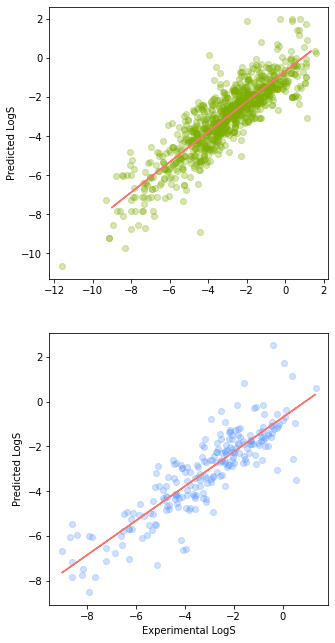

In [42]:
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
model = RandomForestRegressor()

In [45]:
model.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [46]:
y_pred_train = model.predict(X_train)

In [48]:
y_pred_test = model.predict(X_test)

Text(0.5, 0, 'Experimental LogS')

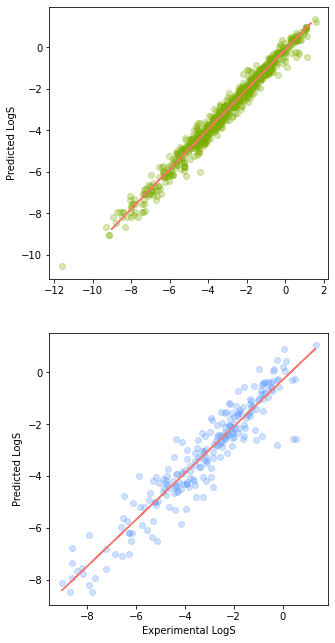

In [49]:
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=y_pred_train, c="#7CAE00", alpha=0.3)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(Y_train, y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

In [50]:
print(model.score(X_train,Y_train))

0.9793232456936658


In [51]:
print(model.score(X_test,Y_test))

0.8872182027757924
